In [172]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from api_import import *
import api_import 

In [173]:
#data = np.genfromtxt("2013_gaz_tracts_36.txt",delimiter=",",)
data = pd.read_csv("../data/gazetter_tracts/2013_gaz_tracts_36.txt",header=0,dtype={'GEOID': np.int64, 
        'ALAND': float, 'AWATER': float, 'ALAND_SQMI': float, 'AWATER_SQMI': float, 
        'INTPTLAT': float, 'INTPTLONG': float})

In [174]:
data.head(5)

,USPS,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,NY,36001000100,2367456,245021,0.914,0.095,42.663754,-73.736909
1,NY,36001000200,2065161,0,0.797,0.000,42.664413,-73.751504
2,NY,36001000300,5779329,55326,2.231,0.021,42.680614,-73.783004
3,NY,36001000401,9017989,134152,3.482,0.052,42.702508,-73.866753
4,NY,36001000403,3138700,0,1.212,0.000,42.676874,-73.805264


In [175]:
#add state, county, county, tract id, block id information to data frame
data['STATE'] = ''
data['STATE_ID'] = ''
data['GEOID'] = data['GEOID'].astype("str")
data['BOROUGH'] = ''
data['COUNTY_ID'] = ''
data['TRACT_ID'] = ''
data['LATMIN'] = 0.0
data['LATMAX'] = 0.0
data['LONGMIN'] = 0.0
data['LONGMAX'] = 0.0
data['ZIPCODE'] = ''
data['FRAC_LAND'] = data['ALAND'] / (data['ALAND'] + data['AWATER'])

## ---IGNORING ZIP CODES SINCE THEY ARE MAIL ROUTES AND NOT ALWAYS MAPPED CORRECTLY TO TRACT + COUNTY CODE COMBINATIONS

In [176]:
#ziplist = zip_tract_dict.keys() #if y[0] == '61']
data.head(5)

,USPS,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,STATE,STATE_ID,BOROUGH,COUNTY_ID,TRACT_ID,LATMIN,LATMAX,LONGMIN,LONGMAX,ZIPCODE,FRAC_LAND
0,NY,36001000100,2367456,245021,0.914,0.095,42.663754,-73.736909,,,,,,0,0,0,0,,0.906211
1,NY,36001000200,2065161,0,0.797,0.000,42.664413,-73.751504,,,,,,0,0,0,0,,1.000000
2,NY,36001000300,5779329,55326,2.231,0.021,42.680614,-73.783004,,,,,,0,0,0,0,,0.990518
3,NY,36001000401,9017989,134152,3.482,0.052,42.702508,-73.866753,,,,,,0,0,0,0,,0.985342
4,NY,36001000403,3138700,0,1.212,0.000,42.676874,-73.805264,,,,,,0,0,0,0,,1.000000


In [177]:
#function to parse GEOID
def parse_geoid(geoidstr):
    return geoidstr[:2],geoidstr[2:5],geoidstr[5:]

In [178]:
#http://msi.nga.mil/MSISiteContent/StaticFiles/Calculators/degree.html to get meters->lat, long
#latitude (NYC) = 40.7 degrees
#1 degree of latitude = 111048 meters
#1 degree of longitude = 84515 meters 
for irow, row in data.iterrows():
    state, county, tract =  parse_geoid(row['GEOID'])
    data.ix[irow,'STATE_ID'] = state
    data.ix[irow,'COUNTY_ID'] = county
    data.ix[irow,'TRACT_ID'] = tract
    #data.ix[irow,'BLOCK_ID'] = block
    length = np.sqrt(row['ALAND'] + row['AWATER'])  #in meters
    dlat = 0.5 * length * (1./111048.)
    dlon = 0.5 * length * (1./84515.)
    data.ix[irow,'LATMIN'], data.ix[irow,'LATMAX'] = row['INTPTLAT'] - dlat, row['INTPTLAT'] + dlat
    data.ix[irow,'LONGMIN'], data.ix[irow,'LONGMAX'] = row['INTPTLONG'] - dlon, row['INTPTLONG'] + dlon

In [179]:
data.loc[data.COUNTY_ID == "061","BOROUGH"] = "Manhattan"
data.loc[data.COUNTY_ID == "047","BOROUGH"] = "Brooklyn"
data.loc[data.COUNTY_ID == "081","BOROUGH"] = "Queens"
data.loc[data.COUNTY_ID == "085","BOROUGH"] = "Staten"
data.loc[data.COUNTY_ID == "005","BOROUGH"] = "Bronx"
data.BOROUGH.unique()

array(['', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten'], dtype=object)

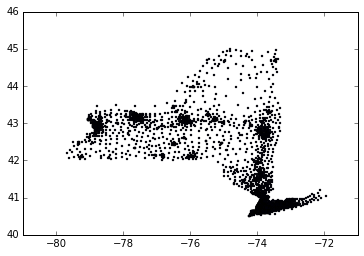

In [180]:
#plot of new york from census tracts
plt.scatter(data['INTPTLONG'],data['INTPTLAT'],s=2)

In [181]:
#Create subsets for nyc 5 boroughs and for manhattan only
nyc = data[(data['COUNTY_ID'] == "061") | (data['COUNTY_ID'] == "047") | 
           (data['COUNTY_ID'] == "005") | (data['COUNTY_ID'] == "081") | 
           (data['COUNTY_ID'] == "085")].reset_index(drop=True)

In [182]:
nyc.set_index(['COUNTY_ID', 'TRACT_ID'],inplace=True,drop=False)

In [184]:
#zip_tract_dict = zip_to_tract()
tract_zip_dict = api_import.tract_to_zip()
for irow, row in nyc.iterrows():
    if (row['COUNTY_ID'],row['TRACT_ID']) in tract_zip_dict.keys():
        nyc.ix[irow,'ZIPCODE'] = tract_zip_dict[(row['COUNTY_ID'],row['TRACT_ID'])]
    else:
        nyc.ix[irow,'ZIPCODE'] = "00000"

In [185]:
manhattan = nyc[(nyc['COUNTY_ID'] == "061")]

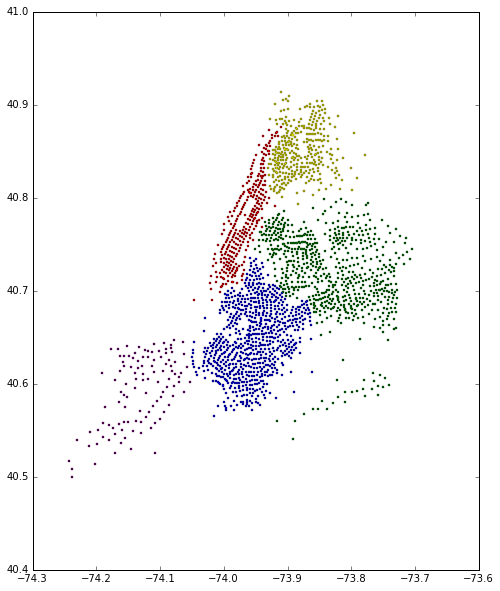

In [186]:
#Plot of NYC color-coded by borough! 
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (8,10)
plt.scatter(nyc['INTPTLONG'],nyc['INTPTLAT'],s=2)
plt.scatter(nyc[nyc['COUNTY_ID'] == "061"]['INTPTLONG'],nyc[nyc['COUNTY_ID'] == "061"]['INTPTLAT'],s=2,color='red',alpha=0.5)
plt.scatter(nyc[nyc['COUNTY_ID'] == "047"]['INTPTLONG'],nyc[nyc['COUNTY_ID'] == "047"]['INTPTLAT'],s=2,color='blue',alpha=0.5)
plt.scatter(nyc[nyc['COUNTY_ID'] == "081"]['INTPTLONG'],nyc[nyc['COUNTY_ID'] == "081"]['INTPTLAT'],s=2,color='green',alpha=0.5)
plt.scatter(nyc[nyc['COUNTY_ID'] == "085"]['INTPTLONG'],nyc[nyc['COUNTY_ID'] == "085"]['INTPTLAT'],s=2,color='purple',alpha=0.5)
plt.scatter(nyc[nyc['COUNTY_ID'] == "005"]['INTPTLONG'],nyc[nyc['COUNTY_ID'] == "005"]['INTPTLAT'],s=2,color='yellow',alpha=0.5)

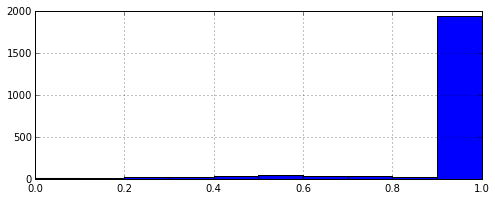

In [187]:
#Fraction of NYC census tracts that are 100% over land = 90%
mpl.rcParams["figure.figsize"] = (8,3)
nyc['FRAC_LAND'].hist(bins=10)

In [188]:
print "fraction of tract census areas 90% land = ",float(len(nyc[nyc['FRAC_LAND'] > 0.90]))/len(nyc['FRAC_LAND'])

fraction of tract census areas 90% land =  0.897092754961


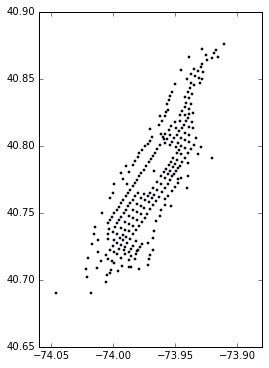

In [189]:
mpl.rcParams["figure.figsize"] = (4,6)
plt.scatter(manhattan['INTPTLONG'],manhattan['INTPTLAT'],s=3)

In [190]:
#print manhattan[:,['LONGMIN','LONGMAX','LATMIN','LATMAX']]
print manhattan.index

COUNTY_ID  TRACT_ID
061        000100  
           000201  
           000202  
           000500  
           000600  
           000700  
           000800  
           000900  
           001001  
           001002  
           001200  
           001300  
           001401  
           001402  
           001501  
           001502  
           001600  
           001800  
           002000  
           002100  
           002201  
           002202  
           002400  
           002500  
           002601  
           002602  
           002700  
           002800  
           002900  
        ...        
           025300  
           025500  
           025700  
           025900  
           026100  
           026300  
           026500  
           026700  
           026900  
           027100  
           027300  
           027500  
           027700  
           027900  
           028100  
           028300  
           028500  
           028700  
           029100  


In [134]:
#--------------------------

###Combine Geographical Data with Population, Economic, Demographic Data

In [207]:
#specify features in census database

census_vars = [["cty", {"description": "County", "name": "COUNTY_ID"}],
               ["tr", {"description": "Tract", "name": "TRACT_ID"}],
["DP03_0051E", {"description": "Total households", "name": "hh_total"}],
["DP03_0052E" , {"description": "Total households < 10,000","name": "hh1"}],
["DP03_0053E" , {"description": "Total households 10,000 to 14,999","name": "hh2"}],
["DP03_0054E" , {"description": "Total households 15,000 to 24,999","name": "hh3"}],
["DP03_0055E" , {"description": "Total households 25,000 to 34,999","name": "hh4"}],
["DP03_0056E" , {"description": "Total households 35,000 to 49,999","name": "hh5"}],
["DP03_0057E" , {"description": "Total households 50,000 to 74,999","name": "hh6"}],
["DP03_0058E" , {"description": "Total households 75,000 to 99,999","name": "hh7"}],
["DP03_0059E" , {"description": "Total households 100,000 to 149,999","name": "hh8"}],
["DP05_0001E" , {"description": "Total population","name": "pop_total"}],
["DP05_0008E" , {"description": "Total population 20 to 24 years old","name": "pop1"}],
["DP05_0009E" , {"description": "Total population 25 to 34 years old","name": "pop2"}],
["DP05_0010E" , {"description": "Total population 35 to 44 years old","name": "pop3"}],
["DP05_0011E" , {"description": "Total population 45 to 54 years old","name": "pop4"}],
["DP05_0012E" , {"description": "Total population 55 to 59 years old","name": "pop5"}],
["DP05_0013E" , {"description": "Total population 60 to 64 years old","name": "pop6"}],
["DP05_0014E" , {"description": "Total population 65 to 74 years old","name": "pop7"}],
["DP05_0015E" , {"description": "Total population 75 to 84 years old","name": "pop8"}],
["DP05_0016E" , {"description": "Total population 85+","name": "pop9"}],
["DP05_0039E" , {"description": "Race: Asian","name": "pop_asian"}],
["DP05_0033E" , {"description": "Race: African American","name": "pop_black"}],
["DP05_0032E" , {"description": "Race: White","name": "pop_white"}],
["DP05_0034E" , {"description": "Race: Native American","name": "pop_native"}],
["DP05_0047E" , {"description": "Race: Native Hawaiian and Other Pacific Islander","name": "pop_pacific"}],
["DP05_0066E" , {"description": "Hispanic and Latino of any race","name": "pop_latino"}]]

census_vars_keys = [x[0] for x in census_vars]
census_vars_names = [x[1]["name"] for x in census_vars]

print census_vars_keys
print census_vars_names

['cty', 'tr', 'DP03_0051E', 'DP03_0052E', 'DP03_0053E', 'DP03_0054E', 'DP03_0055E', 'DP03_0056E', 'DP03_0057E', 'DP03_0058E', 'DP03_0059E', 'DP05_0001E', 'DP05_0008E', 'DP05_0009E', 'DP05_0010E', 'DP05_0011E', 'DP05_0012E', 'DP05_0013E', 'DP05_0014E', 'DP05_0015E', 'DP05_0016E', 'DP05_0039E', 'DP05_0033E', 'DP05_0032E', 'DP05_0034E', 'DP05_0047E', 'DP05_0066E']
['COUNTY_ID', 'TRACT_ID', 'hh_total', 'hh1', 'hh2', 'hh3', 'hh4', 'hh5', 'hh6', 'hh7', 'hh8', 'pop_total', 'pop1', 'pop2', 'pop3', 'pop4', 'pop5', 'pop6', 'pop7', 'pop8', 'pop9', 'pop_asian', 'pop_black', 'pop_white', 'pop_native', 'pop_pacific', 'pop_latino']


In [208]:
bronx_df = api_import.query_census(census_vars_keys, "05")
manhattan_df = api_import.query_census(census_vars_keys, "61")
queens_df = api_import.query_census(census_vars_keys, "81")
brooklyn_df = api_import.query_census(census_vars_keys, "47")
staten_df = api_import.query_census(census_vars_keys, "85")

In [209]:
#Concatenate information for all boroughs
dfs = [manhattan_df,bronx_df,queens_df,brooklyn_df,staten_df]
census_df = pd.concat(dfs)
census_df = census_df.reset_index(drop=True)

In [210]:
census_df.rename(columns=dict(zip(census_vars_keys, census_vars_names)), inplace=True)

In [211]:
#convert all the "strings" to numeric data PRIOR to merging with geographic data
for col in census_df.columns:
    if col not in ['COUNTY_ID', 'TRACT_ID', 'ZIPCODE_ID']:
        census_df[col] = census_df[col].astype(float)

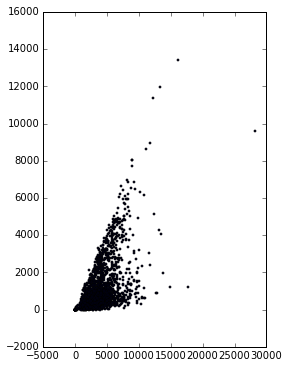

In [212]:
import matplotlib.pyplot as plt
plt.scatter(census_df['pop_total'],census_df['pop_latino'],s=3)

In [213]:
frac_latino = np.array(census_df['pop_latino'] / census_df['pop_total'])
print type(frac_latino)

<type 'numpy.ndarray'>


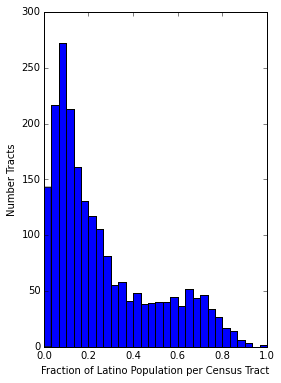

In [214]:
plt.hist(frac_latino[~np.isnan(frac_latino)],bins=30);
plt.xlabel("Fraction of Latino Population per Census Tract")
plt.ylabel("Number Tracts")

In [215]:
census_df.head(5)

,COUNTY_ID,TRACT_ID,hh_total,hh1,hh2,hh3,hh4,hh5,hh6,hh7,...,pop9,pop_asian,pop_black,pop_white,pop_native,pop_pacific,pop_latino,state,county,tract
0,061,000100,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,36,61,100
1,061,000201,940,208,139,235,39,77,142,51,...,34,1328,200,675,29,0,927,36,61,201
2,061,000202,3338,686,384,509,450,386,459,111,...,252,1429,991,3812,0,0,3766,36,61,202
3,061,000500,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,36,61,500
4,061,000600,3912,1061,608,512,389,324,496,152,...,351,6940,877,1262,9,15,3063,36,61,600


In [216]:
census_df.set_index(['COUNTY_ID', 'TRACT_ID'],inplace=True)
census_df.head(5)

0                   hh_total   hh1  hh2  hh3  hh4  hh5  hh6  hh7  hh8  \
COUNTY_ID TRACT_ID                                                      
061       000100           0     0    0    0    0    0    0    0    0   
          000201         940   208  139  235   39   77  142   51   39   
          000202        3338   686  384  509  450  386  459  111  218   
          000500           0     0    0    0    0    0    0    0    0   
          000600        3912  1061  608  512  389  324  496  152  250   

0                   pop_total  ...    pop9  pop_asian  pop_black  pop_white  \
COUNTY_ID TRACT_ID             ...                                            
061       000100            0  ...       0          0          0          0   
          000201         2824  ...      34       1328        200        675   
          000202         8012  ...     252       1429        991       3812   
          000500            0  ...       0          0          0          0   
          000600        11558  ...     351       6940        877       1262   

0                   pop_native  pop_pacific  pop_latino  state  county  tract  
COUNTY_ID TRACT_ID                                                             
061       000100             0            0           0     36      61    100  
          000201            29            0         927     36      61    201  
          000202             0            0        3766     36      61    202  
          000500             0            0           0     36      61    500  
          000600             9           15        3063     36      61    600  

[5 rows x 28 columns]

In [217]:
nyc.head(5)

USPS        GEOID    ALAND   AWATER  ALAND_SQMI  \
COUNTY_ID TRACT_ID                                                   
005       000100     NY  36005000100  1672467  1032658       0.646   
          000200     NY  36005000200   455322   926899       0.176   
          000400     NY  36005000400   912391   602945       0.352   
          001600     NY  36005001600   485079        0       0.187   
          001900     NY  36005001900  1656134  1139660       0.639   

                    AWATER_SQMI   INTPTLAT  INTPTLONG STATE STATE_ID BOROUGH  \
COUNTY_ID TRACT_ID                                                             
005       000100          0.399  40.793492 -73.883532             36   Bronx   
          000200          0.358  40.803486 -73.860438             36   Bronx   
          000400          0.233  40.808915 -73.850488             36   Bronx   
          001600          0.000  40.818848 -73.858076             36   Bronx   
          001900          0.440  40.800999 -73.909373             36   Bronx   

                   COUNTY_ID TRACT_ID     LATMIN     LATMAX    LONGMIN  \
COUNTY_ID TRACT_ID                                                       
005       000100         005   000100  40.786087  40.800898 -73.893262   
          000200         005   000200  40.798192  40.808779 -73.867393   
          000400         005   000400  40.803373  40.814458 -73.857771   
          001600         005   001600  40.815712  40.821984 -73.862197   
          001900         005   001900  40.793470  40.808528 -73.919265   

                      LONGMAX ZIPCODE  FRAC_LAND  
COUNTY_ID TRACT_ID                                
005       000100   -73.873801   11370   0.618259  
          000200   -73.853482   10473   0.329413  
          000400   -73.843206   10473   0.602105  
          001600   -73.853956   10473   1.000000  
          001900   -73.899481   10455   0.592366

In [218]:
nyc.columns

Index([u'USPS', u'GEOID', u'ALAND', u'AWATER', u'ALAND_SQMI', u'AWATER_SQMI', u'INTPTLAT', u'INTPTLONG', u'STATE', u'STATE_ID', u'BOROUGH', u'COUNTY_ID', u'TRACT_ID', u'LATMIN', u'LATMAX', u'LONGMIN', u'LONGMAX', u'ZIPCODE', u'FRAC_LAND'], dtype='object')

In [219]:
census_df.columns

Index([u'hh_total', u'hh1', u'hh2', u'hh3', u'hh4', u'hh5', u'hh6', u'hh7', u'hh8', u'pop_total', u'pop1', u'pop2', u'pop3', u'pop4', u'pop5', u'pop6', u'pop7', u'pop8', u'pop9', u'pop_asian', u'pop_black', u'pop_white', u'pop_native', u'pop_pacific', u'pop_latino', u'state', u'county', u'tract'], dtype='object')

In [224]:
df = nyc.join(census_df, how='inner',lsuffix="",rsuffix="")

In [225]:
len(nyc),len(census_df),len(df)

(2167, 2167, 2167)

In [226]:
import matplotlib
matplotlib.style.use('ggplot')

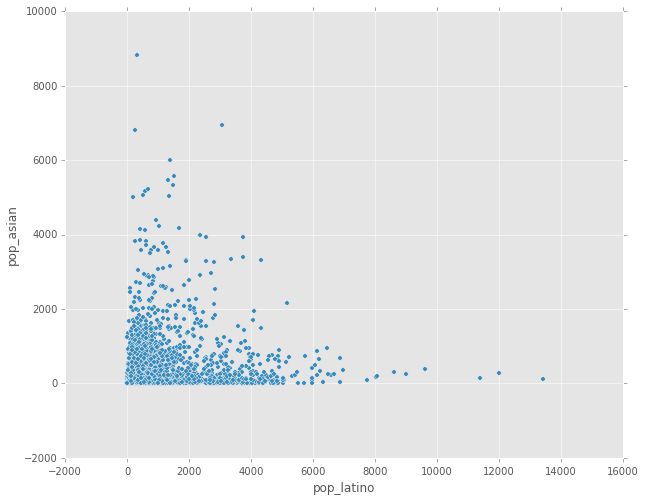

In [237]:
mpl.rcParams["figure.figsize"] = (10,8)
df.plot(kind='scatter', x='pop_latino', y='pop_asian')

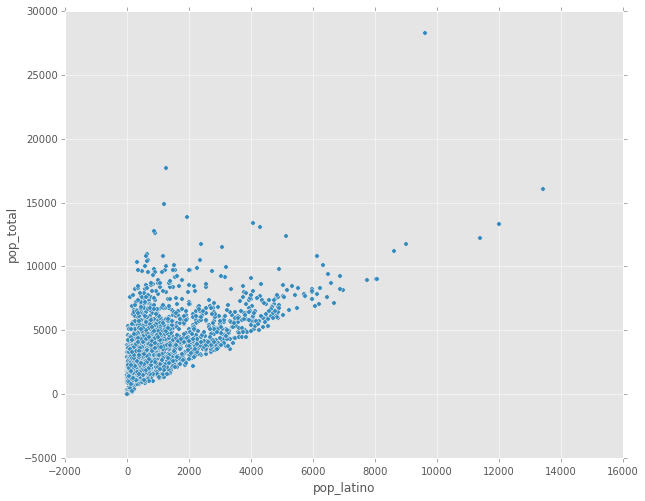

In [238]:
df.plot(kind='scatter', x='pop_latino', y='pop_total')

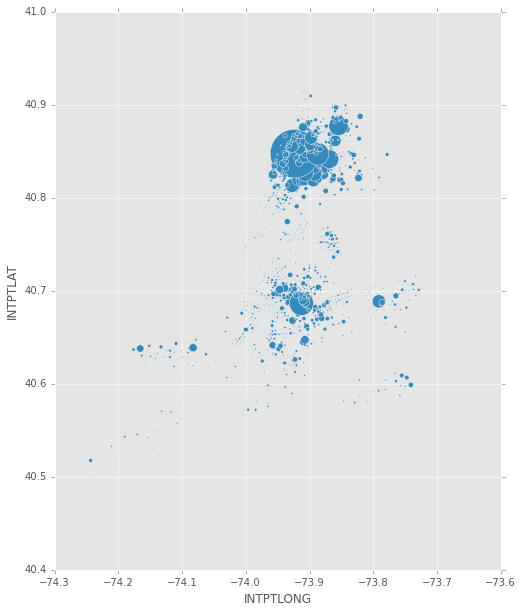

In [264]:
mpl.rcParams["figure.figsize"] = (8,10)
dfsub = df[df['pop_total'] > 0.0]  #dfsub used for plotting where pop_total > 0.0
dfsub.plot(kind='scatter', x='INTPTLONG', y='INTPTLAT',s=0.5*dfsub['pop_latino']/dfsub['pop_asian'])

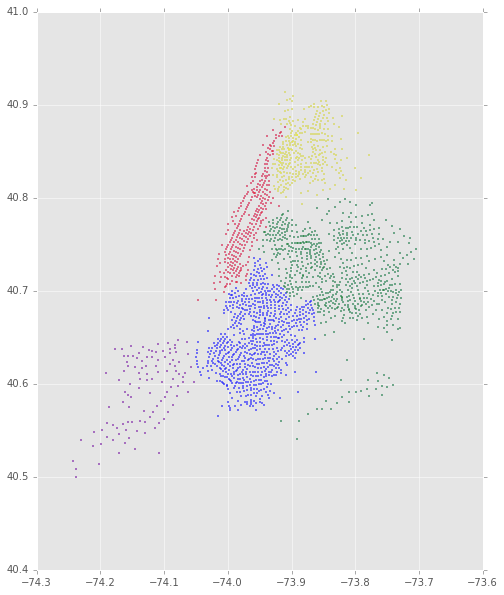

In [261]:
plt.scatter(nyc['INTPTLONG'],nyc['INTPTLAT'],s=2)
plt.scatter(nyc[nyc['COUNTY_ID'] == "061"]['INTPTLONG'],nyc[nyc['COUNTY_ID'] == "061"]['INTPTLAT'],s=2,color='red',alpha=0.5)
plt.scatter(nyc[nyc['COUNTY_ID'] == "047"]['INTPTLONG'],nyc[nyc['COUNTY_ID'] == "047"]['INTPTLAT'],s=2,color='blue',alpha=0.5)
plt.scatter(nyc[nyc['COUNTY_ID'] == "081"]['INTPTLONG'],nyc[nyc['COUNTY_ID'] == "081"]['INTPTLAT'],s=2,color='green',alpha=0.5)
plt.scatter(nyc[nyc['COUNTY_ID'] == "085"]['INTPTLONG'],nyc[nyc['COUNTY_ID'] == "085"]['INTPTLAT'],s=2,color='purple',alpha=0.5)
plt.scatter(nyc[nyc['COUNTY_ID'] == "005"]['INTPTLONG'],nyc[nyc['COUNTY_ID'] == "005"]['INTPTLAT'],s=2,color='yellow',alpha=0.5)